<a href="https://colab.research.google.com/github/gassantos/evolvedtree/blob/master/EvolveDTree_with_Cluster_Sample_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Evaluating the EvolveDTree with Cluster Sampling Preprocessing Approach**





In [0]:
!cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.2 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.2 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [0]:
!cat /proc/cpuinfo

In [0]:
!cat /proc/meminfo

In [0]:
!pip install seaborn scikit-plot mpld3 PyDrive tensorflow deap tpot shap eli5 more-itertools pandas_profiling

     |████████████████████████████████| 798kB 13.9MB/s 
     |████████████████████████████████| 993kB 42.1MB/s 
     |████████████████████████████████| 153kB 40.7MB/s 
     |████████████████████████████████| 81kB 23.7MB/s 
     |████████████████████████████████| 235kB 46.2MB/s 
     |████████████████████████████████| 102kB 26.3MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116679 sha256=0fca20b3dd0711ac61a65a23fcae1091cf89a3000c0f20bdceae70eb377bf953
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
  Created wheel for PyDrive: filename=PyDrive-1.3.1-cp36-none-any.whl size=27435 sha256=cb27ea1d00638e792f4c829f1c9bf4089f47ad21578fc5de05fd92fc8e73cbeb
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
  Created wheel for shap: filename=shap-0.29.3-cp36-cp36m-linux_x86_64.whl size=344733 sha256=93320bea716b75c12a1fda35d077d7b2e0fd68b24ca47c7b26d7695d

# Installing packages for Development

In [0]:
# Code to read csv file into Colaboratory
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4640214321949347799, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7398031858412211112
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 166317082148739209
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11326753997
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9928523520238545728
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
dataset = 'https://drive.google.com/open?id=1GpEfcRdW0HBiMGxKQy1rMfyPpH9xPa9w'
_, id = dataset.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('DATASET_ALUNOS_FORMADOS-EVADIDOS_2012-2018_PTB.csv')

# Create directory to Images
!mkdir "Graficos"; mkdir "Modelos"
!ls -lh

W0805 22:50:57.421490 140585342805888 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

total 48M
-rw-r--r-- 1 root root 2.5K Aug  5 22:50 adc.json
-rw-r--r-- 1 root root  48M Aug  5 22:50 DATASET_ALUNOS_FORMADOS-EVADIDOS_2012-2018_PTB.csv
drwxr-xr-x 2 root root 4.0K Aug  5 22:51 Graficos
drwxr-xr-x 2 root root 4.0K Aug  5 22:51 Modelos
drwxr-xr-x 1 root root 4.0K Aug  2 16:06 sample_data


In [0]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
from builtins import *

import time, collections
import itertools as itools
import graphviz as gvz
import pandas as pd
import numpy as np
import random as rdm
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus as pydot
import scikitplot as skplt
import pickle as pkl
import pandas_profiling

from sklearn import tree as T
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold as SKFold, GridSearchCV as gridSCV
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, classification_report 
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, cohen_kappa_score, precision_score
from sklearn.feature_selection import RFECV
from tpot import TPOTClassifier

from deap import creator, base, tools, algorithms
from scipy import interpolate, stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from joblib import dump, load

import itertools, graphviz, mpld3, requests, json, time, warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import platform, os
if platform.system() == 'Windows' :
    APP='C:/Program Files (x86)/Graphviz2.38/bin/'
    os.environ["PATH"] += os.pathsep + APP

In [0]:
# Settings to Matplotlib    
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 8)

Populating the interactive namespace from numpy and matplotlib


In [0]:
starTime = time.time()

# Plotting Confusion Matrix

In [0]:
def plotConfusionMatrix(matrix, target_names, title="\nMatriz de Confusão\n", cmap=None, accuracy=None, normalize=True):
    
    if cmap is None:
        cmap = plb.get_cmap('Blues')

    plb.figure(figsize=(10,8))
    plb.imshow(matrix, interpolation='nearest', cmap=cmap)
    #plb.title(title)
    plb.colorbar()

    if target_names is not None:
        marks = np.arange(len(target_names))
        plb.xticks(marks, target_names) #, rotation=30)
        plb.yticks(marks, target_names)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]


    thresh = matrix.max() / 1.5 if normalize else matrix.max()
    for i, j in itools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if normalize:
            plb.text(j, i, "{:0.2}".format(matrix[i, j]),
                     horizontalalignment="center",
                     color="red" if matrix[i, j] <= thresh else "red")
        else:
            plb.text(j, i, "{:,}".format(matrix[i, j]),
                     horizontalalignment="center",
                     color="red" if matrix[i, j] > thresh else "red")

    if accuracy is None:
        accuracy = np.trace(matrix) / float(np.sum(matrix))
    
    misclass = 1 - accuracy
    
    plb.figure(1)
    plb.tight_layout()
    plb.xlabel('accuracy={:0.6f}; misclass={:0.6f}'.format(accuracy, misclass))
    
    if normalize is True:
        plb.savefig('Graficos/matrizconf-norm.pdf')
    else:
        plb.savefig('Graficos/matrizconf.pdf')
    plb.show()

# Loading the Students Dataset

In [0]:
starTime = time.time()
data = pd.read_csv('DATASET_ALUNOS_FORMADOS-EVADIDOS_2012-2018_PTB.csv', sep=';')
data.head()

,MATRICULA,ACAOAFIRMATIVA,ENEMLINGUAGEM,ENEMHUMANAS,ENEMNATURAIS,ENEMMATEMATICA,ENEMREDACAO,CURSO,CODTURNOINGRESSO,CODTURNOATUAL,TURNOATUAL,CR,DISCIPLINA,NOTADISC,RESULTDISC,PERIODODISC,ANOINGRESSO,SEMESTREINGRESSO,ANODESVINCULACAO,SEMESTREDESVINCULACAO,IDADE,COR,BAIRRO,CEP,CIDADE,MOBILIDADE,CHCURSADA,ESTADOCIVIL,TRANCAMENTOS,TEMPOPERMANENCIA,SEXO,STATUSFORMACAO
0,113041027,AC,605.8,743.4,706.6,840.1,960.0,41,8,8,INTEGRAL,8.00,GMA00031,61,1,20151,2013,1,2018,1,24,NÃO DECLARADO,JARDIM ICARAÍ,24220330,NITERÓI,0,4498,SOLTEIRO,0,6,M,FORMADO
1,114078004,AC,616.4,602.8,646.4,696.5,840.0,243,8,8,INTEGRAL,7.30,VQI00012,87,1,20152,2014,1,2018,1,22,NÃO DECLARADO,VILA JACI,12211370,SÃO JOSÉ DOS CAMPOS,0,2775,SOLTEIRO,0,5,M,FORMADO
2,113079014,AC,636.2,654.1,617.2,760.0,720.0,244,8,8,INTEGRAL,8.80,FCB00044,80,1,20132,2013,1,2017,2,24,BRANCA,BELA VISTA,28623,NOVA FRIBURGO,0,4300,SOLTEIRO,0,5,F,FORMADO
3,213003111,A1,559.1,568.1,522.0,587.7,700.0,3,4,4,NOTURNO,7.20,SSE00233,80,1,20162,2013,2,2018,1,24,NÃO DECLARADO,CAXITO,21545160,RIO DE JANEIRO,0,3274,SOLTEIRO,0,6,F,FORMADO
4,214062093,AC,545.4,560.9,508.2,528.0,600.0,62,8,8,INTEGRAL,7.06,RAE00001,70,1,20142,2014,2,2015,1,24,NÃO DECLARADO,BARRO VERMELHO,24412330,SÃO GONÇALO,0,330,SOLTEIRO,0,2,F,EVADIDO


In [0]:
data.columns

Index(['MATRICULA', 'ACAOAFIRMATIVA', 'ENEMLINGUAGEM', 'ENEMHUMANAS',
       'ENEMNATURAIS', 'ENEMMATEMATICA', 'ENEMREDACAO', 'CURSO',
       'CODTURNOINGRESSO', 'CODTURNOATUAL', 'TURNOATUAL', 'CR', 'DISCIPLINA',
       'NOTADISC', 'RESULTDISC', 'PERIODODISC', 'ANOINGRESSO',
       'SEMESTREINGRESSO', 'ANODESVINCULACAO', 'SEMESTREDESVINCULACAO',
       'IDADE', 'COR', 'BAIRRO', 'CEP', 'CIDADE', 'MOBILIDADE', 'CHCURSADA',
       'ESTADOCIVIL', 'TRANCAMENTOS', 'TEMPOPERMANENCIA', 'SEXO',
       'STATUSFORMACAO'],
      dtype='object')

In [0]:
# 23 - Admininstração; 7 - Direito; 42 - Eng. Produção; 31 - Ciências da Computação;

flagCurso = False
if flagCurso :
    dataCurso = data.query('CURSO == 7 & ANOINGRESSO <= 2014') #
    print(dataCurso.shape)
    dataCurso.head()

else :
    dataCurso = data.copy()
    print(dataCurso.shape)
    dataCurso.head()

(281673, 32)


# 1) Descriptive Statistics

In [0]:
### Dropping some features
dataCurso = dataCurso.drop(columns=['MATRICULA','PERIODODISC', 'DISCIPLINA', 'NOTADISC', 'RESULTDISC', 'CURSO'])
dataCurso.head()

,ACAOAFIRMATIVA,ENEMLINGUAGEM,ENEMHUMANAS,ENEMNATURAIS,ENEMMATEMATICA,ENEMREDACAO,CODTURNOINGRESSO,CODTURNOATUAL,TURNOATUAL,CR,ANOINGRESSO,SEMESTREINGRESSO,ANODESVINCULACAO,SEMESTREDESVINCULACAO,IDADE,COR,BAIRRO,CEP,CIDADE,MOBILIDADE,CHCURSADA,ESTADOCIVIL,TRANCAMENTOS,TEMPOPERMANENCIA,SEXO,STATUSFORMACAO
0,AC,605.8,743.4,706.6,840.1,960.0,8,8,INTEGRAL,8.00,2013,1,2018,1,24,NÃO DECLARADO,JARDIM ICARAÍ,24220330,NITERÓI,0,4498,SOLTEIRO,0,6,M,FORMADO
1,AC,616.4,602.8,646.4,696.5,840.0,8,8,INTEGRAL,7.30,2014,1,2018,1,22,NÃO DECLARADO,VILA JACI,12211370,SÃO JOSÉ DOS CAMPOS,0,2775,SOLTEIRO,0,5,M,FORMADO
2,AC,636.2,654.1,617.2,760.0,720.0,8,8,INTEGRAL,8.80,2013,1,2017,2,24,BRANCA,BELA VISTA,28623,NOVA FRIBURGO,0,4300,SOLTEIRO,0,5,F,FORMADO
3,A1,559.1,568.1,522.0,587.7,700.0,4,4,NOTURNO,7.20,2013,2,2018,1,24,NÃO DECLARADO,CAXITO,21545160,RIO DE JANEIRO,0,3274,SOLTEIRO,0,6,F,FORMADO
4,AC,545.4,560.9,508.2,528.0,600.0,8,8,INTEGRAL,7.06,2014,2,2015,1,24,NÃO DECLARADO,BARRO VERMELHO,24412330,SÃO GONÇALO,0,330,SOLTEIRO,0,2,F,EVADIDO


In [0]:
pandas_profiling.ProfileReport(dataCurso)

Number of variables,26
Number of observations,281673
Total Missing (%),0.0%
Total size in memory,55.9 MiB
Average record size in memory,208.0 B
Numeric,16
Categorical,9
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [0]:
dataCurso.columns

Index(['ACAOAFIRMATIVA', 'ENEMLINGUAGEM', 'ENEMHUMANAS', 'ENEMNATURAIS',
       'ENEMMATEMATICA', 'ENEMREDACAO', 'CODTURNOINGRESSO', 'CODTURNOATUAL',
       'TURNOATUAL', 'CR', 'ANOINGRESSO', 'SEMESTREINGRESSO',
       'ANODESVINCULACAO', 'SEMESTREDESVINCULACAO', 'IDADE', 'COR', 'BAIRRO',
       'CEP', 'CIDADE', 'MOBILIDADE', 'CHCURSADA', 'ESTADOCIVIL',
       'TRANCAMENTOS', 'TEMPOPERMANENCIA', 'SEXO', 'STATUSFORMACAO'],
      dtype='object')

In [0]:
print(dataCurso.shape)
dataUnique = dataCurso.drop_duplicates(keep='first')
print(dataUnique.shape)

(281673, 26)
(12969, 26)


# Get classes and apply categoric mapping (one hot encoded) to feature vectors

In [0]:
allClasses = dataUnique['STATUSFORMACAO'].values

In [0]:
allFeatures = dataUnique.copy()
allFeatures.head()

,ACAOAFIRMATIVA,ENEMLINGUAGEM,ENEMHUMANAS,ENEMNATURAIS,ENEMMATEMATICA,ENEMREDACAO,CODTURNOINGRESSO,CODTURNOATUAL,TURNOATUAL,CR,ANOINGRESSO,SEMESTREINGRESSO,ANODESVINCULACAO,SEMESTREDESVINCULACAO,IDADE,COR,BAIRRO,CEP,CIDADE,MOBILIDADE,CHCURSADA,ESTADOCIVIL,TRANCAMENTOS,TEMPOPERMANENCIA,SEXO,STATUSFORMACAO
0,AC,605.8,743.4,706.6,840.1,960.0,8,8,INTEGRAL,8.00,2013,1,2018,1,24,NÃO DECLARADO,JARDIM ICARAÍ,24220330,NITERÓI,0,4498,SOLTEIRO,0,6,M,FORMADO
1,AC,616.4,602.8,646.4,696.5,840.0,8,8,INTEGRAL,7.30,2014,1,2018,1,22,NÃO DECLARADO,VILA JACI,12211370,SÃO JOSÉ DOS CAMPOS,0,2775,SOLTEIRO,0,5,M,FORMADO
2,AC,636.2,654.1,617.2,760.0,720.0,8,8,INTEGRAL,8.80,2013,1,2017,2,24,BRANCA,BELA VISTA,28623,NOVA FRIBURGO,0,4300,SOLTEIRO,0,5,F,FORMADO
3,A1,559.1,568.1,522.0,587.7,700.0,4,4,NOTURNO,7.20,2013,2,2018,1,24,NÃO DECLARADO,CAXITO,21545160,RIO DE JANEIRO,0,3274,SOLTEIRO,0,6,F,FORMADO
4,AC,545.4,560.9,508.2,528.0,600.0,8,8,INTEGRAL,7.06,2014,2,2015,1,24,NÃO DECLARADO,BARRO VERMELHO,24412330,SÃO GONÇALO,0,330,SOLTEIRO,0,2,F,EVADIDO


In [0]:
allClasses

array(['FORMADO', 'FORMADO', 'FORMADO', ..., 'EVADIDO', 'EVADIDO',
       'EVADIDO'], dtype=object)

In [0]:
labelEncoder = LabelEncoder()
classes = labelEncoder.fit_transform(allClasses)
classes

array([1, 1, 1, ..., 0, 0, 0])

In [0]:
print("Quantidade de Campos NaN no Dataset: \n")
print(allFeatures.isnull().sum())

Quantidade de Campos NaN no Dataset: 

ACAOAFIRMATIVA            0
ENEMLINGUAGEM             0
ENEMHUMANAS               0
ENEMNATURAIS              0
ENEMMATEMATICA            0
ENEMREDACAO               0
CODTURNOINGRESSO          0
CODTURNOATUAL             0
TURNOATUAL               15
CR                        0
ANOINGRESSO               0
SEMESTREINGRESSO          0
ANODESVINCULACAO          0
SEMESTREDESVINCULACAO     0
IDADE                     0
COR                       0
BAIRRO                    0
CEP                       0
CIDADE                    0
MOBILIDADE                0
CHCURSADA                 0
ESTADOCIVIL               0
TRANCAMENTOS              0
TEMPOPERMANENCIA          0
SEXO                      0
STATUSFORMACAO            0
dtype: int64


In [0]:
print("Quantidade de Campos NaN no Dataset: \n")
allFeatures = allFeatures.fillna(1000)
print(allFeatures.isnull().sum())

Quantidade de Campos NaN no Dataset: 

ACAOAFIRMATIVA           0
ENEMLINGUAGEM            0
ENEMHUMANAS              0
ENEMNATURAIS             0
ENEMMATEMATICA           0
ENEMREDACAO              0
CODTURNOINGRESSO         0
CODTURNOATUAL            0
TURNOATUAL               0
CR                       0
ANOINGRESSO              0
SEMESTREINGRESSO         0
ANODESVINCULACAO         0
SEMESTREDESVINCULACAO    0
IDADE                    0
COR                      0
BAIRRO                   0
CEP                      0
CIDADE                   0
MOBILIDADE               0
CHCURSADA                0
ESTADOCIVIL              0
TRANCAMENTOS             0
TEMPOPERMANENCIA         0
SEXO                     0
STATUSFORMACAO           0
dtype: int64


In [0]:
allFeatures.dtypes

ACAOAFIRMATIVA            object
ENEMLINGUAGEM            float64
ENEMHUMANAS              float64
ENEMNATURAIS             float64
ENEMMATEMATICA           float64
ENEMREDACAO              float64
CODTURNOINGRESSO           int64
CODTURNOATUAL              int64
TURNOATUAL                object
CR                       float64
ANOINGRESSO                int64
SEMESTREINGRESSO           int64
ANODESVINCULACAO           int64
SEMESTREDESVINCULACAO      int64
IDADE                      int64
COR                       object
BAIRRO                    object
CEP                       object
CIDADE                    object
MOBILIDADE                 int64
CHCURSADA                  int64
ESTADOCIVIL               object
TRANCAMENTOS               int64
TEMPOPERMANENCIA           int64
SEXO                      object
STATUSFORMACAO            object
dtype: object

In [0]:
print(allFeatures.shape)
allFeatures.head()

(12969, 26)


,ACAOAFIRMATIVA,ENEMLINGUAGEM,ENEMHUMANAS,ENEMNATURAIS,ENEMMATEMATICA,ENEMREDACAO,CODTURNOINGRESSO,CODTURNOATUAL,TURNOATUAL,CR,ANOINGRESSO,SEMESTREINGRESSO,ANODESVINCULACAO,SEMESTREDESVINCULACAO,IDADE,COR,BAIRRO,CEP,CIDADE,MOBILIDADE,CHCURSADA,ESTADOCIVIL,TRANCAMENTOS,TEMPOPERMANENCIA,SEXO,STATUSFORMACAO
0,AC,605.8,743.4,706.6,840.1,960.0,8,8,INTEGRAL,8.00,2013,1,2018,1,24,NÃO DECLARADO,JARDIM ICARAÍ,24220330,NITERÓI,0,4498,SOLTEIRO,0,6,M,FORMADO
1,AC,616.4,602.8,646.4,696.5,840.0,8,8,INTEGRAL,7.30,2014,1,2018,1,22,NÃO DECLARADO,VILA JACI,12211370,SÃO JOSÉ DOS CAMPOS,0,2775,SOLTEIRO,0,5,M,FORMADO
2,AC,636.2,654.1,617.2,760.0,720.0,8,8,INTEGRAL,8.80,2013,1,2017,2,24,BRANCA,BELA VISTA,28623,NOVA FRIBURGO,0,4300,SOLTEIRO,0,5,F,FORMADO
3,A1,559.1,568.1,522.0,587.7,700.0,4,4,NOTURNO,7.20,2013,2,2018,1,24,NÃO DECLARADO,CAXITO,21545160,RIO DE JANEIRO,0,3274,SOLTEIRO,0,6,F,FORMADO
4,AC,545.4,560.9,508.2,528.0,600.0,8,8,INTEGRAL,7.06,2014,2,2015,1,24,NÃO DECLARADO,BARRO VERMELHO,24412330,SÃO GONÇALO,0,330,SOLTEIRO,0,2,F,EVADIDO


In [0]:
nameFeatures = list(allFeatures)
nameFeatures

['ACAOAFIRMATIVA',
 'ENEMLINGUAGEM',
 'ENEMHUMANAS',
 'ENEMNATURAIS',
 'ENEMMATEMATICA',
 'ENEMREDACAO',
 'CODTURNOINGRESSO',
 'CODTURNOATUAL',
 'TURNOATUAL',
 'CR',
 'ANOINGRESSO',
 'SEMESTREINGRESSO',
 'ANODESVINCULACAO',
 'SEMESTREDESVINCULACAO',
 'IDADE',
 'COR',
 'BAIRRO',
 'CEP',
 'CIDADE',
 'MOBILIDADE',
 'CHCURSADA',
 'ESTADOCIVIL',
 'TRANCAMENTOS',
 'TEMPOPERMANENCIA',
 'SEXO',
 'STATUSFORMACAO']

In [0]:
for c in allFeatures.columns:
    if allFeatures[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(allFeatures[c].values))
        allFeatures[c] = lbl.transform(list(allFeatures[c].values))

# Approach of the Cluster Sampling Stratification with K-means (k = 10)

### Default execution of the K-means:

      KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
      n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
      random_state=None, tol=0.0001, verbose=0)

In [0]:
# Data Clustering
KCLUSTER=10
kmeans = KMeans(n_clusters=KCLUSTER, random_state=42, algorithm="elkan")
kmeans.fit(allFeatures)

KMeans(algorithm='elkan', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [0]:
groups = kmeans.labels_
len(groups)

12969

In [0]:
np.unique(groups)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [0]:
dataFeatures = allFeatures.copy()
dataFeatures['CLUSTER'] = kmeans.labels_
dataFeatures.reset_index(inplace=True)
dataFeatures.head()

,index,ACAOAFIRMATIVA,ENEMLINGUAGEM,ENEMHUMANAS,ENEMNATURAIS,ENEMMATEMATICA,ENEMREDACAO,CODTURNOINGRESSO,CODTURNOATUAL,TURNOATUAL,CR,ANOINGRESSO,SEMESTREINGRESSO,ANODESVINCULACAO,SEMESTREDESVINCULACAO,IDADE,COR,BAIRRO,CEP,CIDADE,MOBILIDADE,CHCURSADA,ESTADOCIVIL,TRANCAMENTOS,TEMPOPERMANENCIA,SEXO,STATUSFORMACAO,CLUSTER
0,0,1,605.8,743.4,706.6,840.1,960.0,8,8,1,8.00,2013,1,2018,1,24,4,871,2799,205,0,4498,1,0,6,1,1,2
1,1,1,616.4,602.8,646.4,696.5,840.0,8,8,1,7.30,2014,1,2018,1,22,4,2101,43,300,0,2775,1,0,5,1,1,6
2,2,1,636.2,654.1,617.2,760.0,720.0,8,8,1,8.80,2013,1,2017,2,24,1,181,6480,206,0,4300,1,0,5,0,1,5
3,3,0,559.1,568.1,522.0,587.7,700.0,4,4,3,7.20,2013,2,2018,1,24,4,348,1249,264,0,3274,1,0,6,0,1,6
4,4,1,545.4,560.9,508.2,528.0,600.0,8,8,1,7.06,2014,2,2015,1,24,4,170,3291,294,0,330,1,0,2,0,0,4


In [0]:
print(dataFeatures.CLUSTER.dtype)
np.unique(dataFeatures.CLUSTER, return_counts=True)

int32


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([1726, 1480, 1308, 1361, 2450, 1304,  543, 1424, 1259,  114]))

In [0]:
# Preparar um método

nfolds = 10
folds = [ [] for i in range(nfolds) ]
print(len(folds))

for cid,ccount in zip(*np.unique(dataFeatures.CLUSTER,return_counts=True)):
    
    x = dataFeatures[(dataFeatures.CLUSTER == cid) & (dataFeatures.STATUSFORMACAO == 0)].index.values
    [folds[np.random.randint(nfolds)].append(i) for i in x]
    
    x = dataFeatures[(dataFeatures.CLUSTER == cid) & (dataFeatures.STATUSFORMACAO == 1)].index.values
    [folds[np.random.randint(nfolds)].append(i) for i in x]

10


In [0]:
# Preparar um método

FOLD = [-1 for i in range(len(dataFeatures))] 

for i,f in enumerate(folds):
    for j in f:
        FOLD[j] = i 
    
dataFeatures['FOLD'] = FOLD

In [0]:
np.unique(dataFeatures.FOLD, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1320, 1284, 1291, 1375, 1270, 1299, 1261, 1323, 1293, 1253]))

In [0]:
for fold in np.unique(dataFeatures.FOLD):
    print("Fold [",fold,"]: ", np.unique(dataFeatures[dataFeatures.FOLD==fold].STATUSFORMACAO, return_counts=True))

Fold [ 0 ]:  (array([0, 1]), array([987, 333]))
Fold [ 1 ]:  (array([0, 1]), array([985, 299]))
Fold [ 2 ]:  (array([0, 1]), array([964, 327]))
Fold [ 3 ]:  (array([0, 1]), array([1042,  333]))
Fold [ 4 ]:  (array([0, 1]), array([964, 306]))
Fold [ 5 ]:  (array([0, 1]), array([987, 312]))
Fold [ 6 ]:  (array([0, 1]), array([985, 276]))
Fold [ 7 ]:  (array([0, 1]), array([979, 344]))
Fold [ 8 ]:  (array([0, 1]), array([994, 299]))
Fold [ 9 ]:  (array([0, 1]), array([965, 288]))


# Cluster Quantitative Analysis: Dropouts vs Graduates

### a) Dropouts proportional by cluster

In [0]:
print("K[0]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 0) & (dataFeatures.FOLD == 0)]))
print("K[1]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 0) & (dataFeatures.FOLD == 1)]))
print("K[2]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 0) & (dataFeatures.FOLD == 2)]))
print("K[3]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 0) & (dataFeatures.FOLD == 3)]))
print("K[4]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 0) & (dataFeatures.FOLD == 4)]))
print("K[5]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 0) & (dataFeatures.FOLD == 5)]))
print("K[6]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 0) & (dataFeatures.FOLD == 6)]))
print("K[7]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 0) & (dataFeatures.FOLD == 7)]))
print("K[8]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 0) & (dataFeatures.FOLD == 8)]))
print("K[9]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 0) & (dataFeatures.FOLD == 9)]))

K[0]:  987
K[1]:  985
K[2]:  964
K[3]:  1042
K[4]:  964
K[5]:  987
K[6]:  985
K[7]:  979
K[8]:  994
K[9]:  965


### b) Graduates proportional by cluster

In [0]:
print("K[0]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 1) & (dataFeatures.FOLD == 0)]))
print("K[1]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 1) & (dataFeatures.FOLD == 1)]))
print("K[2]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 1) & (dataFeatures.FOLD == 2)]))
print("K[3]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 1) & (dataFeatures.FOLD == 3)]))
print("K[4]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 1) & (dataFeatures.FOLD == 4)]))
print("K[5]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 1) & (dataFeatures.FOLD == 5)]))
print("K[6]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 1) & (dataFeatures.FOLD == 6)]))
print("K[7]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 1) & (dataFeatures.FOLD == 7)]))
print("K[8]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 1) & (dataFeatures.FOLD == 8)]))
print("K[9]: ", len(dataFeatures[(dataFeatures.STATUSFORMACAO == 1) & (dataFeatures.FOLD == 9)]))

K[0]:  333
K[1]:  299
K[2]:  327
K[3]:  333
K[4]:  306
K[5]:  312
K[6]:  276
K[7]:  344
K[8]:  299
K[9]:  288


In [0]:
dataFeatures.head()

,index,ACAOAFIRMATIVA,ENEMLINGUAGEM,ENEMHUMANAS,ENEMNATURAIS,ENEMMATEMATICA,ENEMREDACAO,CODTURNOINGRESSO,CODTURNOATUAL,TURNOATUAL,CR,ANOINGRESSO,SEMESTREINGRESSO,ANODESVINCULACAO,SEMESTREDESVINCULACAO,IDADE,COR,BAIRRO,CEP,CIDADE,MOBILIDADE,CHCURSADA,ESTADOCIVIL,TRANCAMENTOS,TEMPOPERMANENCIA,SEXO,STATUSFORMACAO,CLUSTER,FOLD
0,0,1,605.8,743.4,706.6,840.1,960.0,8,8,1,8.00,2013,1,2018,1,24,4,871,2799,205,0,4498,1,0,6,1,1,2,9
1,1,1,616.4,602.8,646.4,696.5,840.0,8,8,1,7.30,2014,1,2018,1,22,4,2101,43,300,0,2775,1,0,5,1,1,6,1
2,2,1,636.2,654.1,617.2,760.0,720.0,8,8,1,8.80,2013,1,2017,2,24,1,181,6480,206,0,4300,1,0,5,0,1,5,9
3,3,0,559.1,568.1,522.0,587.7,700.0,4,4,3,7.20,2013,2,2018,1,24,4,348,1249,264,0,3274,1,0,6,0,1,6,5
4,4,1,545.4,560.9,508.2,528.0,600.0,8,8,1,7.06,2014,2,2015,1,24,4,170,3291,294,0,330,1,0,2,0,0,4,6


# Testing the validation para o Cluster Sampling

In [0]:
qtdFold = np.unique(dataFeatures.FOLD)
for k in qtdFold:
    if k == 9:
        break

    itensFold = dataFeatures[dataFeatures.FOLD == k]
    classes = itensFold.STATUSFORMACAO.values
    features = itensFold.drop(columns = ['STATUSFORMACAO', 'FOLD', 'CLUSTER'])


# Data Preprocessing Unsupervised through Clusterization

In [0]:
names = ["KNN","LogRegression","RBF-SVM","DecisionTree","RandomForest","NeuralNet","AdaBoost","NaiveBayes","QDA"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(),
    SVC(kernel="linear", C=0.025),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

In [0]:
# Training through Unsupervised Stratified KFold
bestAccuracyFolds = {}
bestAccuracyFolds['Model'] = 'Classifier','Accuracy','MCC','ROC','AUC-ROC','Report','Precision','F-Score'
maxAccuracyFold = {}

bestAccuracy = 0.0
bestClassifier = None
bestMeanAccuracy = {}
bestMCC = 0.0
bestROC = 0.0
bestReport = None
XValidationSetFold = {}
yValidationSetFold = {}
XTrainSetFold = {}
yTrainSetFold = {}

print("================================== Starting the Training Stage =========================\n")

qtdFold = np.unique(dataFeatures.FOLD)
for k in qtdFold:
    if k == 9:
        break

    itensFold = dataFeatures[dataFeatures.FOLD == k]
    classes = itensFold.STATUSFORMACAO.values
    features = itensFold.drop(columns = ['STATUSFORMACAO', 'FOLD', 'CLUSTER'])
    
    X_train, X_validation, y_train, y_validation = train_test_split(features, classes, test_size=0.1, random_state=42)    
    print("Training - (", X_train.shape, "): ", len(X_train))
    print("\nFOLD %d\t- Acc, Mcc, Auc, Prec, Fscore, Kappa"%(k))
       
    c = 0
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        prediction = clf.predict(X_validation)
        acc = accuracy_score(y_validation, prediction)
        mcc = matthews_corrcoef(y_validation, prediction)
        roc = roc_curve(y_validation, prediction)
        rauc = roc_auc_score(y_validation, prediction)
        report = classification_report(y_validation, prediction)
        prec = precision_score(y_validation, prediction)
        fscore = f1_score(y_validation, prediction)
        kappa = cohen_kappa_score(y_validation, prediction)
        matrix = confusion_matrix(y_validation, prediction)


        if acc >= bestAccuracy:
            bestAccuracy = acc
            bestClassifier = clf
            maxAccuracyFold[k] = X_train, y_train, X_validation, y_validation
            bestMCC = mcc
            bestROC = roc
            bestReport = report

            bestAccuracyFolds[name] = clf, acc, mcc, roc, rauc, report, prec, fscore, kappa, matrix

        print("C[%d]\t- %s had performance of %.4f, %.4f, %.4f, %.4f, %.4f, %.4f"%(c,name,acc,mcc,rauc,prec,fscore,kappa))
        c=c+1


================================== Starting the Training Stage =========================

Training - ( (1188, 26) ):  1188

FOLD 0	- Acc, Mcc, Auc, Prec, Fscore, Kappa
C[0]	- KNN had performance of 0.9697, 0.9249, 0.9624, 0.9459, 0.9459, 0.9249
C[1]	- LogRegression had performance of 0.9848, 0.9625, 0.9730, 1.0000, 0.9722, 0.9618
C[2]	- RBF-SVM had performance of 0.9773, 0.9438, 0.9595, 1.0000, 0.9577, 0.9422
C[3]	- DecisionTree had performance of 0.9773, 0.9438, 0.9595, 1.0000, 0.9577, 0.9422
C[4]	- RandomForest had performance of 0.8788, 0.6970, 0.7838, 1.0000, 0.7241, 0.6539
C[5]	- NeuralNet had performance of 0.9773, 0.9438, 0.9595, 1.0000, 0.9577, 0.9422
C[6]	- AdaBoost had performance of 0.9848, 0.9625, 0.9730, 1.0000, 0.9722, 0.9618
C[7]	- NaiveBayes had performance of 0.9470, 0.8826, 0.9632, 0.8409, 0.9136, 0.8757
C[8]	- QDA had performance of 0.9697, 0.9298, 0.9789, 0.9024, 0.9487, 0.9273
Training - ( (1155, 26) ):  1155

FOLD 1	- Acc, Mcc, Auc, Prec, Fscore, Kappa
C[0]	- KNN 

In [0]:
itensFoldTest = dataFeatures[dataFeatures.FOLD == 9]
classeTest = itensFoldTest.STATUSFORMACAO.values
featureTest = itensFoldTest.drop(columns=['STATUSFORMACAO', 'FOLD', 'CLUSTER'])
#XV_train, XV_test, YV_train, YV_test = train_test_split(featureTest, classeTest, test_size=0.1, random_state=42)

In [0]:
bestAccuracyFolds

{'AdaBoost': (AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                     n_estimators=50, random_state=None),
  1.0,
  1.0,
  (array([0., 0., 1.]), array([0., 1., 1.]), array([2, 1, 0])),
  1.0,
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        96\n           1       1.00      1.00      1.00        37\n\n    accuracy                           1.00       133\n   macro avg       1.00      1.00      1.00       133\nweighted avg       1.00      1.00      1.00       133\n',
  1.0,
  1.0,
  1.0,
  array([[96,  0],
         [ 0, 37]])),
 'DecisionTree': (DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                         max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort

In [0]:
# save the model to disk
for key, value in bestAccuracyFolds.items():
    filename = 'Modelos/'+key+'.sav'
    if key != 'Model': pkl.dump(value[0], open(filename, 'wb')) 
        
!ls -lh "Modelos"

total 652K
-rw-r--r-- 1 root root  33K Aug  5 23:05 AdaBoost.sav
-rw-r--r-- 1 root root 3.0K Aug  5 23:05 DecisionTree.sav
-rw-r--r-- 1 root root 520K Aug  5 23:05 KNN.sav
-rw-r--r-- 1 root root 1.1K Aug  5 23:05 LogRegression.sav
-rw-r--r-- 1 root root  75K Aug  5 23:05 NeuralNet.sav
-rw-r--r-- 1 root root 9.4K Aug  5 23:05 RBF-SVM.sav


In [0]:
bestAccuracy

1.0

In [0]:
clfDT = None 
accuracy = None
mcc = None
roc = None
report = None
precision = None
fscore = None
kappa = None
matrix = []

if bestAccuracyFolds.get('DecisionTree') != None :
    clfDT, accuracy, mcc, roc, rauc, report, precision, fscore, kappa, matrix = bestAccuracyFolds.get('DecisionTree')
    
else :
    clfDT = T.DecisionTreeClassifier()
    clfDT = clfDT.fit(XV_train, YV_train)
    print(clfDT)

# Visualization of The Better Classifier

In [0]:
dataClass = T.export_graphviz(clfDT, out_file=None, filled=True, rounded=True, proportion=True,
            special_characters=True, feature_names=nameFeatures, class_names=['Dropped','Graduated'], node_ids=True)  
graph = gvz.Source(dataClass)
graph.render("Graficos/clfDTfeatureSelection") # Save in PDF

'Graficos/clfDTfeatureSelection.pdf'

In [0]:
filename = ''
models = os.listdir(path='Modelos/')
for model in models :
    if model == 'DecisionTree.sav':
        filename = 'Modelos/'+model
        print(filename)

Modelos/DecisionTree.sav


In [0]:
# load the model from disk
clfDT = pkl.load(open(filename, 'rb'))
y_pred = clfDT.predict(featureTest)
print(y_pred)

[1 1 1 ... 0 0 0]


In [0]:
# Accuracy for Decision Tree classifier with criterion as gini index
if accuracy == None:
    accuracy = accuracy_score(classeTest, y_pred)*100
print("\nAccuracy is", accuracy)


Accuracy is 1.0


In [0]:
# Evaluate the Matthew’s correlation coefficient (MCC) for binary classes
if mcc == None:
    mcc = matthews_corrcoef(classeTest, y_pred)
print("\nMatthews Correlation Coeficient is",mcc)


Matthews Correlation Coeficient is 1.0


In [0]:
if kappa == None:
    kappa = cohen_kappa_score(classeTest, y_pred)
print("\nThe function Cohen Kappa Score is", kappa)


The function Cohen Kappa Score is 1.0


In [0]:
if rauc == None:
    rauc = roc_auc_score(classeTest, y_pred)
print("\nArea Under the Receiver Operating Characteristic Curve (ROC AUC) is", rauc)


Area Under the Receiver Operating Characteristic Curve (ROC AUC) is 1.0


In [0]:
if precision == None:
    precision = precision_score(classeTest, y_pred)
print("\nPrecision is",precision)


Precision is 1.0


In [0]:
if fscore == None:
    fscore = f1_score(classeTest, y_pred)
print("\nF1-Score is",fscore)


F1-Score is 1.0


In [0]:
#if matrix.all() == None:
matrix = confusion_matrix(classeTest, y_pred)
print("\nConfusion Matrix is \n\n\n",matrix)


Confusion Matrix is 


 [[956   9]
 [  8 280]]


In [0]:
if report == None:
    report = classification_report(classeTest, y_pred)
print("\nClassification Report is \n\n\n",report)


Classification Report is 


               precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       1.00      1.00      1.00        37

    accuracy                           1.00       133
   macro avg       1.00      1.00      1.00       133
weighted avg       1.00      1.00      1.00       133



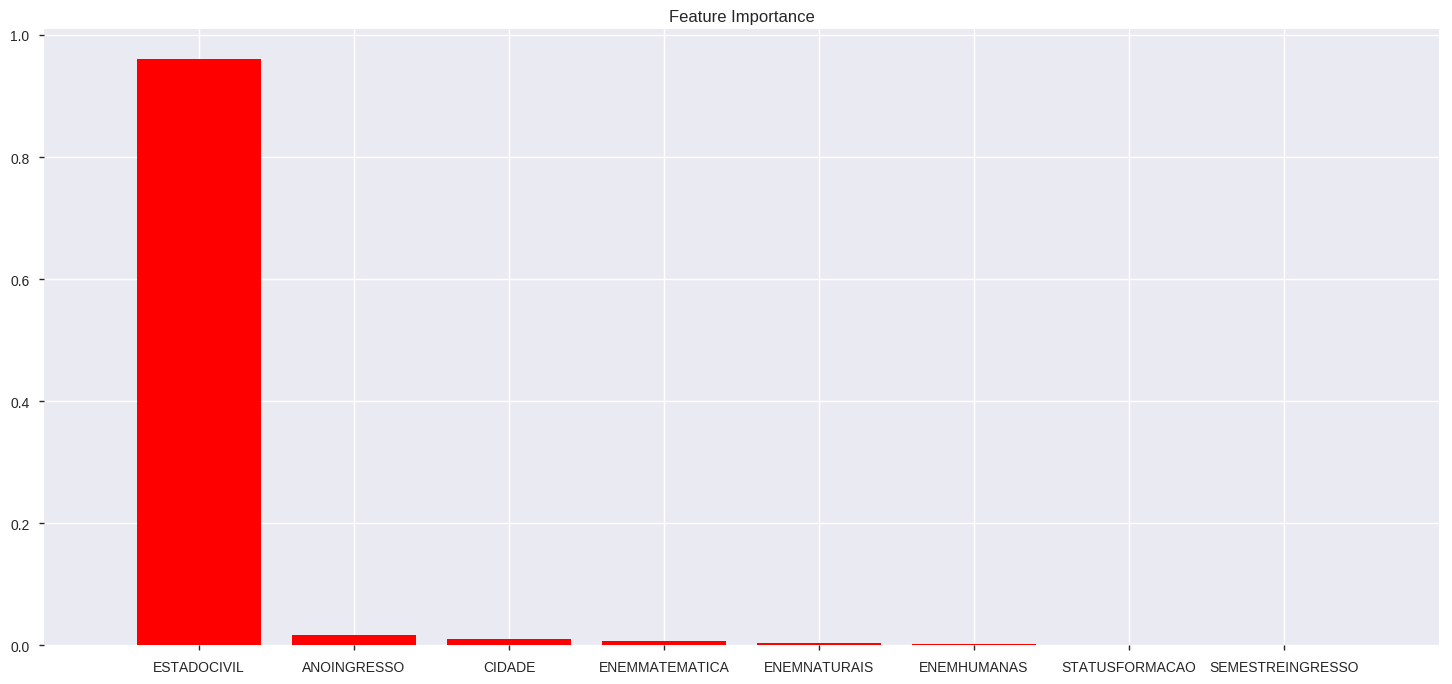

<Figure size 800x550 with 0 Axes>

In [0]:
skplt.estimators.plot_feature_importances(clfDT, feature_names=nameFeatures, max_num_features=8, figsize=(18, 8))
plt.show()
plb.savefig('Graficos/feature-importance.pdf')

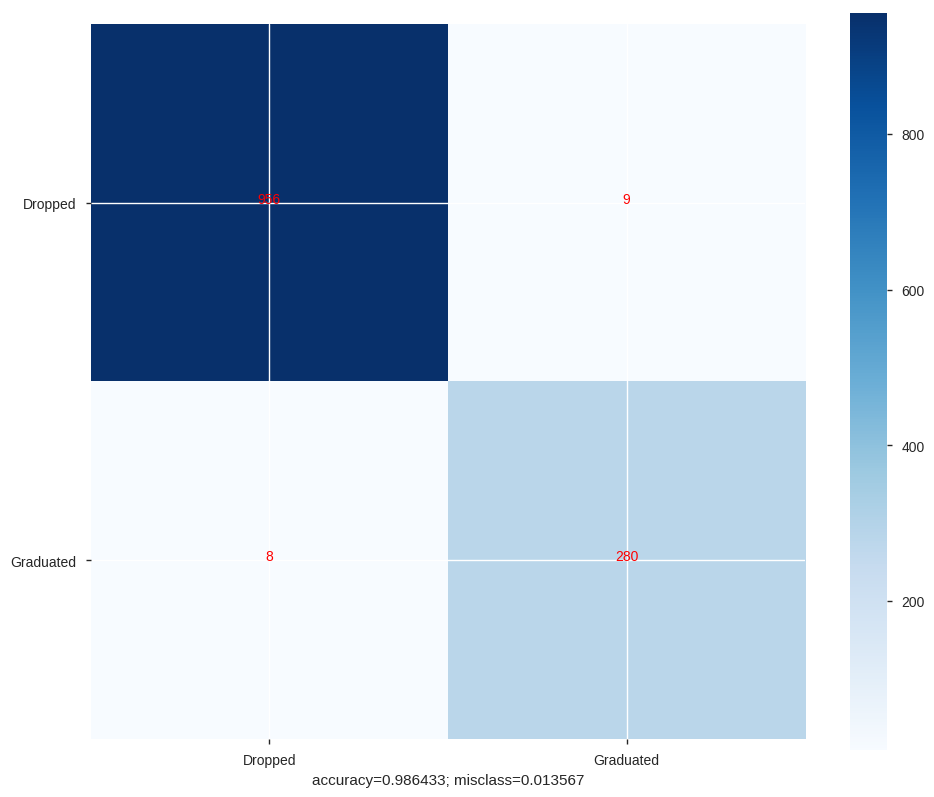

In [0]:
plotConfusionMatrix(matrix, target_names=['Dropped','Graduated'], normalize=False)

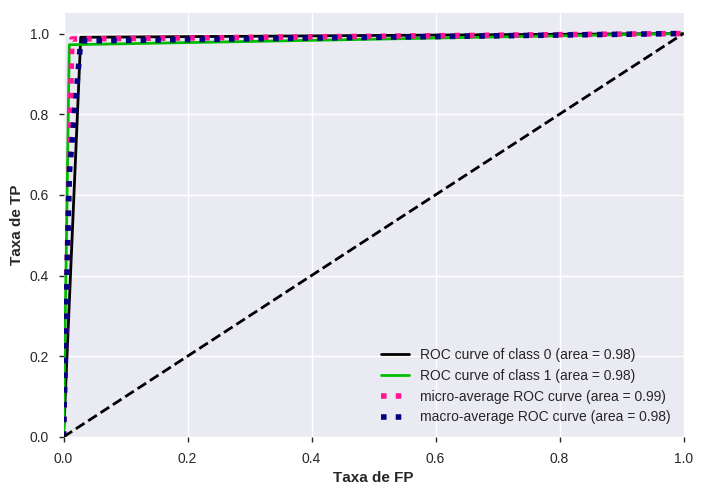

<Figure size 800x550 with 0 Axes>

In [0]:
predicted_probas = clfDT.predict_proba(featureTest)
skplt.metrics.plot_roc(classeTest, predicted_probas)
plb.title('', fontsize=11, fontweight='bold')
plb.xlabel('Taxa de FP', fontsize=11, fontweight='bold')
plb.ylabel('Taxa de TP', fontsize=11, fontweight='bold')
plb.show()
plb.savefig('Graficos/roc-curve.pdf')

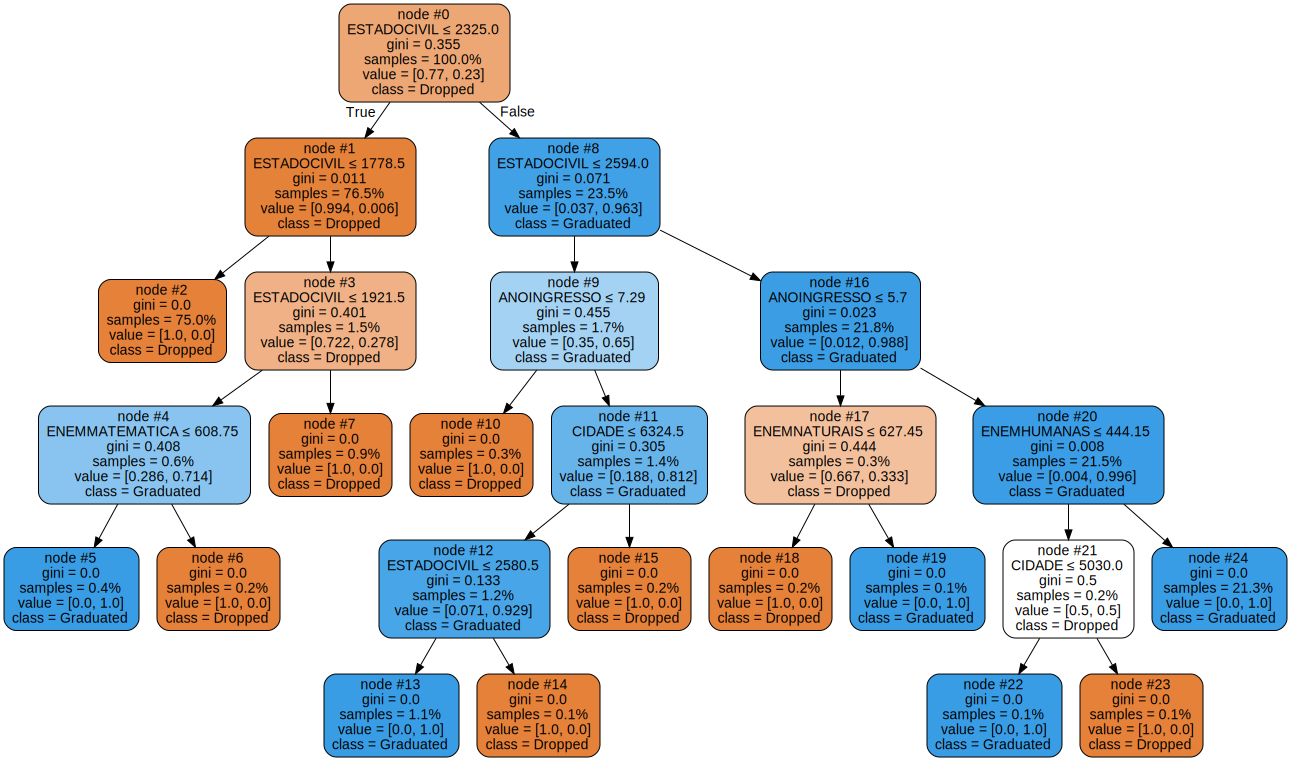

In [0]:
dataClass = T.export_graphviz(clfDT, out_file=None, filled=True, rounded=True, proportion=True,
            special_characters=True, feature_names=nameFeatures, class_names=['Dropped','Graduated'], node_ids=True)  
graph = gvz.Source(dataClass)
graph

In [0]:
print("--- %s seconds ---" % (time.time() - starTime))

--- 838.7720820903778 seconds ---
